# Agent based model for control of COVID-19 on a college campus

Jeffrey Kantor \\
August, 2020

This notebook presents an agent-based model for the transmission and control of COVID-19 in a campus-like environment. The model is implemented using
[SimPy](https://simpy.readthedocs.io/en/latest/), an easy-to-use python framework for developing simulations of discrete-event processes.

The agents are surrogates for individuals in a semi-isolated population typical of those found on residential college campuses. Individuals within the population are assumed to be in frequent contact in a 'well-mixed' environment, and in limited contact with individuals outside of the campus community. The agents simulate the progress of COVID-19 through the various stages of the disease. The agents are implemented as instances of a Python class.

Transmission of COVID-19 is modeled as a SimPy process involving the random contact of an agent in an infectious state with an individual in a susceptible state. The frequency of contact is derived from empirical estimates of $R_0$.

The dynamics and management of COVID-19 outbreaks are also modeled as SimPy processes. The processes include:

* Contact and disease transmission from individual outside of the campus population.
* Self-reporting and isolation of symptomatic individuals.
* Testing and isolation of infectious individuals.
* Return of recovered individuals to the campus population.
* Real-time reporting



**This is a work in progress -- major changes and work required**

* document elements of the model
* reparameterize to use R0 as an input parameter
* add data logging for isolation and testing instances
* create a UI

## References

**SimPy**

* [SimPy repository](https://gitlab.com/team-simpy/simpy)
* [SimPy: Simulating Real-World Processes With Python](https://realpython.com/simpy-simulating-with-python/)

**Agent-based modeling**

* Bonabeau, Eric. "Agent-based modeling: Methods and techniques for simulating human systems." Proceedings of the national academy of sciences 99.suppl 3 (2002): 7280-7287.

## Installation and Imports

SimPy is not typically included with standard Python distributions. The following cell imports and installs the latest version of SimPy from the PyPi repository.

In [1]:
!pip install simpy

All initializations and imports needed to run the code in this notebook are consolidated into the following cell.

In [100]:
%matplotlib inline

import simpy
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Agent Model

The agent model encapsulates details of the disease progression in an individual following an infective event. The progress of the disease is characterized by three parameters

| parameter | default value | description |
| :--: | :--: | :--- |
| $t_{latent}$ | 3 d | mean latency period |
| $t_{infect}$ | 8 d | mean infectious period prior to recovery |
| $p_{s|i}$ | 0.3 | probability of becoming symptomatic following infection |

On initialization, the agent is assigned a "susceptible" state and individual values of the key parameters. The agent remains in the initial state until it receives an "infect" event. Upon infection, the agent state progresses to a latent "exposed" state. 

Following infection, the agent transitions to either and infectious state, either with or without symptoms. The rate of transition is governed by a Poisson process with rate $1/t_{latent}$. The probability of the symptomatic state is $p_{s|i}$.



In [185]:
class Person():

    def __init__(self, env, id, status="susceptible", t_latent=3.0, t_infect=8.0, psi=0.3):
        self.env = env              # simulation environment
        self.id = id                # agent id for post-processing
        self.data = []              # log events for this agent
        self.change_status(status)  # status
        self.infect = env.event()   # infection event
        self.t_latent = t_latent    # latency period in days
        self.t_infect = t_infect    # infectious period in days
        self.psi = psi              # probability of symptoms following infection
        env.process(self.run())     # register agent with the simulation environment

    def log_status(self):
        self.data.append([self.env.now, self.status])

    def change_status(self, status):
        self.status = status
        self.data.append([self.env.now, status])

    def run(self):
        yield self.infect
        self.change_status("exposed")
        yield env.timeout(random.expovariate(1/self.t_latent))
        if random.uniform(0, 1) <= self.psi:
            self.change_status("asymptomatic")
            yield env.timeout(random.expovariate(1/(self.t_infect)))
            self.change_status("asymptomatic-recovered")
        else:
            self.change_status("symptomatic")
            yield env.timeout(random.expovariate(1/(self.t_infect)))
            self.change_status("symptomatic-recovered")
        
        self.change_status("recovered")

## Infection process

In [186]:
def infect(env, n):
    """Infect n susceptible individuals."""
    for s in random.sample(population, n):
        s.infect.succeed()
    yield env.timeout(0)

## COVID-19 Transmission Process

In [187]:
def covid(env, beta):
    while True:
        # Poisson process
        yield env.timeout(random.expovariate(beta))

        # pick two individuals at random
        a, b = random.sample(population, 2)

        # transmit infection
        if a.status == "susceptible" and b.status in ("asymptomatic", "symptomatic"):
            a.infect.succeed()
        elif a.status in ("asymptomatic", "symptomatic") and b.status == "susceptible":
            b.infect.succeed()


## Transmission from exogeneous sources and super-spreader events

In [188]:
def super_spreader_events(env):
    p_infect = 0.01
    while True:
        yield env.timeout(7.0)
        for s in population:
            if s.status == "susceptible":
                if random.uniform(0, 1) < p_infect:
                    #print(f"Student {s.name} infected by superspreader event on day {env.now:4.1f}")
                    s.infect.succeed()


## Testing and Isolation of Asymptomatic Individuals

In [196]:
def testing(env, t_repeat=3, t_delay=1):
    p_sensitivity = 0.7
    p_selectivity = 99.5
    yield env.timeout(t_delay)
    while True:
        yield env.timeout(t_repeat - t_delay)
        pos = set(s for s in population if s.status in ("symptomatic", "asymptomatic") and random.uniform(0,1) <= p_sensitivity)
        yield env.timeout(t_delay)
        for s in pos:
            if s in population:
                isolation.add(s)
                population.remove(s)

## Isolation of Symptomatic Individuals

In [197]:
def isolate_symptomatics(env):
    """Isolate symptomatics perfectly every day"""
    while True:
        yield env.timeout(1.0)
        tmp = set(s for s in population if s.status == "symptomatic")
        for s in tmp:
            isolation.add(s)
            population.remove(s)

## Recovery and Return

In [198]:
def return_healthy(env):
    while True:
        yield env.timeout(0.5)
        tmp = set(s for s in isolation if not s.status in ("asymptomatic", "symptomatic"))
        for s in tmp:
            isolation.remove(s)
            population.add(s)


## Simulation

In [205]:
N = 400

# create simulation environment
env = simpy.Environment()

# create campus population
population = set(Person(env, k) for k in range(0, N))
isolation = set()

# start up all processes
env.process(infect(env, 2))
env.process(covid(env, 0.8*N))
env.process(super_spreader_events(env))
env.process(testing(env, t_repeat=2, t_delay=0))
env.process(isolate_symptomatics(env))
env.process(return_healthy(env))

# run simulation
env.run(until=120)

## Post-Processing Simulation Data

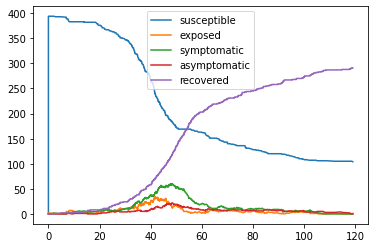

In [206]:
# post-processing
data = [[s.id, t, status] for s in population for t, status in s.data]

# create pandas data frame
df = pd.DataFrame(data, columns=["id", "time", "status"]).sort_values(["time", "id"]).set_index("time")

U = (df["status"] == "susceptible").cumsum()
E = (df["status"] == "exposed").cumsum()
S = (df["status"] == "symptomatic").cumsum()
SR = (df["status"] == "symptomatic-recovered").cumsum()
A = (df["status"] == "asymptomatic").cumsum()
AR = (df["status"] == "asymptomatic-recovered").cumsum()
R = (df["status"] == "recovered").cumsum()

u = U - E
e = E - (S + A)
s = S - SR
a = A - AR
r = R

plt.plot(u, label="susceptible")
plt.plot(e, label="exposed")
plt.plot(s, label="symptomatic")
plt.plot(a, label="asymptomatic")
plt.plot(r, label="recovered")
plt.legend()

# post-processing
##log = np.array(log)
#plt.plot(log[:,0], log[:, 1:]);
#plt.legend(['susceptible', 'exposed', 'asymptomatic', 'symptomatic', 'recovered'])
#plt.xlabel('days')
#plt.ylabel('number');